In [ ]:
# !pip install aedes

In [2]:
import pandas as pd
import aedes
from aedes.remote_sensing_utils import df_to_ee_points, generate_random_ee_points
from aedes.remote_sensing_utils import visualize_on_map, get_satellite_measures_from_points
from aedes.automl_utils import perform_classification
from sklearn.model_selection import train_test_split
import joblib

In [56]:
# Get bounding boxes
# corn_bbox = [[[121.9104170782,16.5983135882],
#               [122.310549019,16.5983135882],
#               [122.310549019,17.3416019547],
#               [121.9104170782,17.3416019547],
#               [121.9104170782,16.5983135882]]] # Isabela, Cagayan Valley

corn_bbox = [[[120.5567821572,16.8118988341],
              [120.8984653584,16.8118988341],
              [120.8984653584,18.3597964702],
              [120.5567821572,18.3597964702],
              [120.5567821572,16.8118988341]]] # ilocos region

# corn_bbox = [[[124.2227947286,7.0956485805],
#               [124.4957685044,7.0956485805],
#               [124.4957685044,7.7634292191],
#               [124.2227947286,7.7634292191],
#               [124.2227947286,7.0956485805]]] # ARMM, https://psa.gov.ph/ricosit-main/corn

rice_bbox = [[[120.8134002782,15.4285948282],
              [121.2418621048,15.4285948282],
              [121.2418621048,15.9390544231],
              [120.8134002782,15.9390544231],
              [120.8134002782,15.4285948282]]] # Nueva Ecija

sugarcane_bbox = [[[122.9880519396,10.7109895144],
                   [123.0360789539,10.7109895144],
                   [123.0360789539,10.7654439068],
                   [122.9880519396,10.7654439068],
                   [122.9880519396,10.7109895144]]] # Bacolod Area

coconut_bbox = [[[125.2337980122,7.0783490176],
                 [125.562760219,7.0783490176],
                 [125.562760219,7.5758566798],
                 [125.2337980122,7.5758566798],
                 [125.2337980122,7.0783490176]]] # Davao Region

banana_bbox = [[[125.6722435834,7.2859952131],
                [125.6906201747,7.2859952131],
                [125.6906201747,7.309293621],
                [125.6722435834,7.309293621],
                [125.6722435834,7.2859952131]]]# Panabo, Davao del Norte

In [4]:
# initialize satellite data pull
aedes.remote_sensing_utils.initialize()

In [57]:
# Get satellite data for each bounding box with their correspending labels
dfs = []
labels = ['rice', 'corn', 'sugarcane', 'coconut', 'banana']
bboxes = [rice_bbox, corn_bbox, sugarcane_bbox, coconut_bbox, banana_bbox]
for i in list(range(len(labels))):
    aoi = bboxes[i]
    points = generate_random_ee_points(aoi, sample_points=300)
    %time df = get_satellite_measures_from_points(points, aoi, date_from='2022-01-01', date_to='2022-01-31')
    df['label'] = labels[i]
    dfs.append(df)

CPU times: user 12 s, sys: 1.26 s, total: 13.2 s
Wall time: 29min 48s
CPU times: user 12.3 s, sys: 1.26 s, total: 13.6 s
Wall time: 29min 15s
CPU times: user 12.2 s, sys: 1.34 s, total: 13.5 s
Wall time: 30min 35s
CPU times: user 12.3 s, sys: 1.45 s, total: 13.8 s
Wall time: 30min 13s
CPU times: user 12.1 s, sys: 1.23 s, total: 13.4 s
Wall time: 29min 51s


In [58]:
# Concatenate all dfs
full_df = pd.concat(dfs)

In [7]:
# Save data
full_df.to_csv('data/pads_satellite_agriculture_data.csv', index=False)

In [59]:
# Set features and target
features = ['ndvi', 'fapar', 'ndbi', 'ndwi', 'ndmi', 'aerosol',
       'surface_temperature', 'precipitation_rate', 'relative_humidity']

target = 'label'
X = full_df[features]
y = full_df[target]

In [60]:
X.shape

(1500, 9)

In [61]:
X.isna().sum()

ndvi                   87
fapar                   0
ndbi                   87
ndwi                   87
ndmi                   87
aerosol                 0
surface_temperature     1
precipitation_rate      2
relative_humidity       2
dtype: int64

In [62]:
full_nonnull_df = full_df.dropna()
X_nonnull = full_nonnull_df[features]
y_nonnull = full_nonnull_df[target]

In [63]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X_nonnull, y_nonnull, test_size=0.3, random_state=42)

In [64]:
y_test.value_counts()

coconut      92
banana       91
sugarcane    91
rice         83
corn         67
Name: label, dtype: int64


Generation 1 - Current best internal CV score: 0.9806873610974908

Generation 2 - Current best internal CV score: 0.9806873610974908

Generation 3 - Current best internal CV score: 0.980713769985367

Generation 4 - Current best internal CV score: 0.9929000608860209

Generation 5 - Current best internal CV score: 0.9939031003340402

Generation 6 - Current best internal CV score: 0.9939031003340402

Generation 7 - Current best internal CV score: 0.9939031003340402

Generation 8 - Current best internal CV score: 0.9939031003340402

Generation 9 - Current best internal CV score: 0.9939031003340402

Generation 10 - Current best internal CV score: 0.9949182699513605

Generation 11 - Current best internal CV score: 0.9949182699513605

Generation 12 - Current best internal CV score: 0.9949194943031149

Generation 13 - Current best internal CV score: 0.9949194943031149

Generation 14 - Current best internal CV score: 0.9959346639204352

Generation 15 - Current best internal CV score: 0.9969631

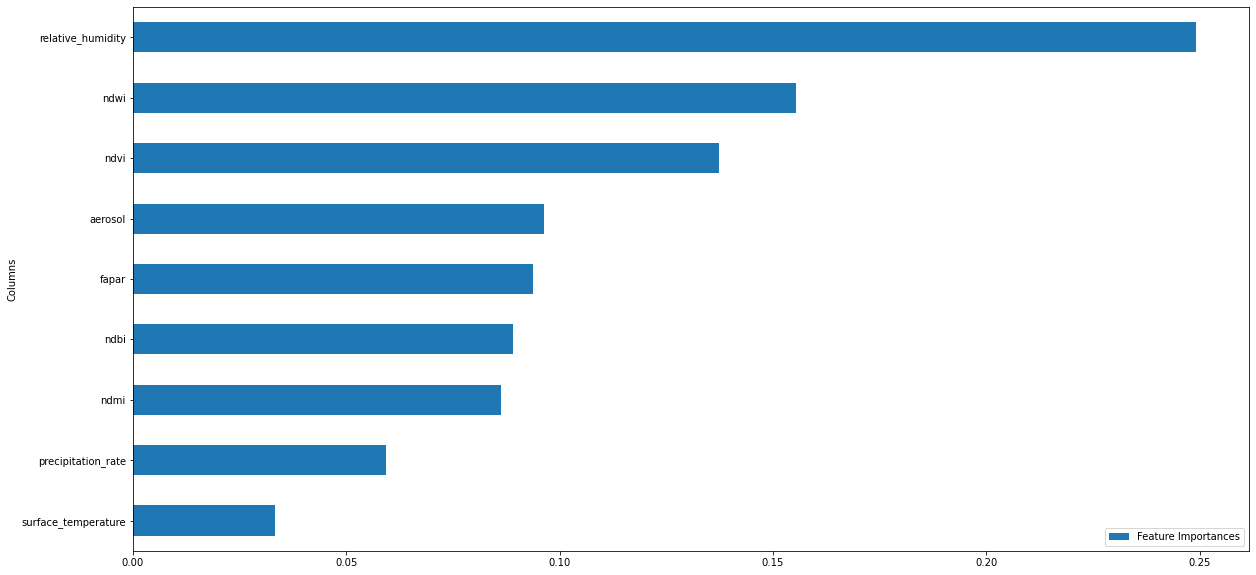

In [65]:
# Perform AutoML
# Switch scoring model to weighted or micro for multiclass
model, feature_imps_df = perform_classification(X_train, y_train, scoring='f1_weighted')

In [66]:
# Get predictions on unseen data
y_pred = model.predict(X_test)

In [67]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      banana       1.00      1.00      1.00        91
     coconut       1.00      1.00      1.00        92
        corn       0.99      1.00      0.99        67
        rice       1.00      0.99      0.99        83
   sugarcane       1.00      1.00      1.00        91

    accuracy                           1.00       424
   macro avg       1.00      1.00      1.00       424
weighted avg       1.00      1.00      1.00       424



In [35]:
# Get model accuracy
# model.score(y_test, y_pred)

In [36]:
# Save model as pickle file
joblib.dump(model, 'model/pads_model.pkl')

['model/pads_model.pkl']

In [51]:
# Get predictions for another set of points from bounding boxes
# new_area = [[[122.9880519396,10.7109895144],
#                    [123.0360789539,10.7109895144],
#                    [123.0360789539,10.7654439068],
#                    [122.9880519396,10.7654439068],
#                    [122.9880519396,10.7109895144]]] # Bacolod Area

new_area = corn_bbox

northern_mindanao_bbox = [[[124.4182312062,7.7469144156],
            [125.2243423035,7.7469144156],
            [125.2243423035,8.4136629661],
            [124.4182312062,8.4136629661],
            [124.4182312062,7.7469144156]]] # Northern Mindanao, Cagayan De Oro Area

southern_mindanao_bbox = [[[124.3021773866,6.1353270024],
            [125.3388243487,6.1353270024],
            [125.3388243487,6.5593429042],
            [124.3021773866,6.5593429042],
            [124.3021773866,6.1353270024]]] # Souther Mindanao, Koronadal Area

northern_negros_bbox = [[[122.9258321246,10.3045953428],
                         [123.3155946454,10.3045953428],
                         [123.3155946454,10.6213613777],
                         [122.9258321246,10.6213613777],
                         [122.9258321246,10.3045953428]]] # northern negros

southern_negros_bbox = [[[122.9246412238,9.1380548206],
                         [123.2162000259,9.1380548206],
                         [123.2162000259,9.4729839157],
                         [122.9246412238,9.4729839157],
                         [122.9246412238,9.1380548206]]] # southern negros, dumaguete area

northern_luzon_bbox = [[[120.7035879172,14.8311826122],
                        [121.4887241401,14.8311826122],
                        [121.4887241401,18.4651462379],
                        [120.7035879172,18.4651462379],
                        [120.7035879172,14.8311826122]]] # northern luzon area

new_dfs = []
new_bboxes = [northern_mindanao_bbox, southern_mindanao_bbox, 
              northern_negros_bbox, southern_negros_bbox, 
              northern_luzon_bbox] + bboxes

for i in list(range(len(new_bboxes))):
    aoi = new_bboxes[i]
    points = generate_random_ee_points(aoi, sample_points=300)
    %time new_df = get_satellite_measures_from_points(points, aoi, date_from='2022-01-01', date_to='2022-01-31')
    nonnull_new_df = new_df.dropna()
    nonnull_new_df['predicted_labels'] = model.predict(nonnull_new_df[features])
    new_dfs.append(nonnull_new_df)

CPU times: user 12.7 s, sys: 1.87 s, total: 14.5 s
Wall time: 32min 52s
CPU times: user 12.1 s, sys: 1.48 s, total: 13.5 s
Wall time: 32min 37s
CPU times: user 12.1 s, sys: 1.47 s, total: 13.5 s
Wall time: 34min 2s
CPU times: user 12 s, sys: 1.35 s, total: 13.3 s
Wall time: 33min 11s
CPU times: user 12.4 s, sys: 1.41 s, total: 13.8 s
Wall time: 28min 37s
CPU times: user 12.5 s, sys: 1.62 s, total: 14.1 s
Wall time: 31min 3s
CPU times: user 12.5 s, sys: 1.37 s, total: 13.9 s
Wall time: 33min 5s
CPU times: user 12.1 s, sys: 1.34 s, total: 13.4 s
Wall time: 31min 45s
CPU times: user 12.1 s, sys: 1.53 s, total: 13.6 s
Wall time: 32min 6s
CPU times: user 11.9 s, sys: 1.4 s, total: 13.3 s
Wall time: 30min 12s


In [52]:
full_new_df = pd.concat(new_dfs)

In [53]:
full_new_df.shape

(2123, 14)

In [54]:
full_new_df.predicted_labels.value_counts()

sugarcane    839
rice         412
coconut      330
banana       303
corn         239
Name: predicted_labels, dtype: int64

In [55]:
full_new_df.to_csv("data/pads_satellite_agriculture_predicted_crop_diversity.csv", index=False)